In [2]:
#Load In packages and data
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
os.chdir('/Users/samspreen/Desktop/Spring2020/ECON4020/Project 2/')
data = pd.read_csv('Caltrans_bid_preference.csv')
pd.options.display.float_format = '{:.2f}'.format

The first function in the cell below applys the bid discount to the bids submitted by small business bidders. The second function takes the logarithm of the bids. When applying both functions to the dataframe, I am creating a new column (variable) to store the transformed bids.

In [3]:
def adjustbid(x):
    if x['Small Business Preference'] == 1:
        adjusted = x['Bid '] * 0.95
    elif x['Small Business Preference'] == 0:
        adjusted = x['Bid '] 
    return adjusted

data['new bid'] = data.apply(adjustbid, axis = 1)

def logged(x):
    logbid = math.log(x,10)
    return logbid

data['Log Bid'] = data['Bid '].apply(logged)

The loop below goes through the dataframe and ranks the bids in ascending order so that the lowest bid is given the value 1, the second lowest 2, etc.

In [4]:
auctions = pd.Series(data['Project ID']).unique()
data2 = pd.DataFrame()
for i in list(auctions):
    df = data[data['Project ID'] == i]
    df['rank'] = df['new bid'].rank()
    df = pd.DataFrame(df)
    data2 = data2.append(df)

data = data2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Below I create two new variables, the first is the total number of bidders in each auctions, the second is the difference between the bid submitted and the engineers' estimate

In [5]:
data['Bidder Count'] = data['Number of Small Business Bidders'] + data['Number of Large Business Bidders']
data['diff'] = data['Bid '] - data['Estimate']

Next we must remove auctions with errors and other characteristics that will make our ability to estimate more difficult. To begin, we remove auctions with only 1 bidder as this undermines the assumptions of a competitive auction environment. We also remove the auctions with bids in the upper and lower 1% quantiles as these auctions have outlier values that will make Kernel Density Estimation incredibly difficult.

In [6]:
#Auctions with only one bidder
one_bidder = data[data['Bidder Count']==1]
one_bidder = list(one_bidder['Project ID'])
#Quantiles to drop outliers 
low_quant = float(data['Bid '].quantile(0.01))
upper_quant = float(data['Bid '].quantile(0.99))
below = data[data['Bid '] < low_quant]
upper = data[data['Bid '] > upper_quant]
below_auctions = pd.Series(below['Project ID']).unique()
upper_auctions = pd.Series(upper['Project ID']).unique()
remove = list(below_auctions) + list(upper_auctions) + list(one_bidder)

Lastly, several auctions had repeat bidders and other data integrity errors and these auctions have the ID's seen in the "invalid_auctions" variable. I now loop through the dataframe and remove the auctions identified above and in "invalid_auctions."

In [7]:
invalid_auctions = [2188, 2124, 2065, 2082]
invalid_auctions = invalid_auctions + remove
for i in invalid_auctions:
    i = int(i)
    data.drop(data.loc[data['Project ID']==i].index, inplace = True)

In [8]:
sns.set(style="darkgrid")

In [9]:
pal = sns.color_palette("Reds")
print(pal.as_hex())
#['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']

['#fedbcc', '#fcaf93', '#fc8161', '#f44f39', '#d52221', '#aa1016']


Text(0, 0.5, 'Frequency')

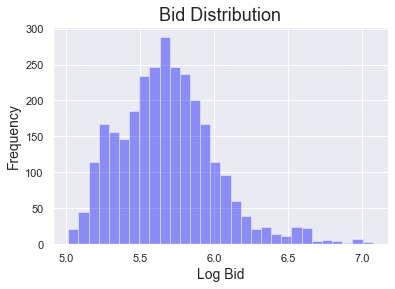

In [10]:
p1 = sns.distplot(data['Log Bid'],kde = False, bins = 30, color='Blue')
plt.title('Bid Distribution', fontsize=18)
plt.xlabel('Log Bid', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
#p1.figure.savefig('bidhist.jpg', format='jpeg', dpi=800)

In [11]:
def fivesummary(x):
    maximum = np.max(x)
    minimum = np.min(x)
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    med = np.median(x)
    return minimum, q1, med, q3, maximum

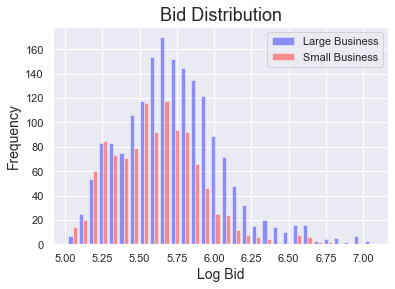

In [12]:
big = data[data['Small Business Preference']==0]
small = data[data['Small Business Preference']==1]
p2 = sns.distplot([big['Log Bid'],small['Log Bid']], color = ['Blue','Red'], kde = False, bins = 30)
plt.title('Bid Distribution', fontsize=18)
plt.xlabel('Log Bid', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(['Large Business', 'Small Business'], loc='upper right');
#p2.figure.savefig('bidhist2.jpg', format='jpeg', dpi=800)

In [13]:
print(fivesummary(big['Bid ']))
print(fivesummary(small['Bid ']))
print(fivesummary(data['Bid ']))
print(fivesummary(data['Bidder Count']))

(106210.0, 318227.0, 514209.0, 846282.0, 11777770.0)
(103845.0, 245786.0, 395526.0, 601299.0, 5965853.0)
(103845.0, 288362.25, 467452.5, 738929.125, 11777770.0)
(2, 4.0, 5.0, 7.0, 20)


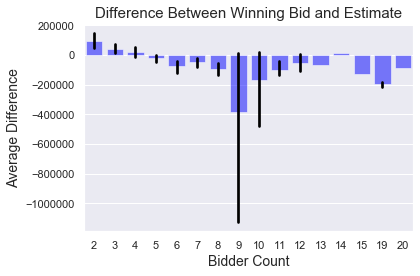

In [75]:
winner = data[data['rank']==1]
p3 = sns.barplot(x=winner['Bidder Count'], y=winner['diff'], saturation=1, 
                 color = 'Blue', alpha=0.5, errcolor='black')
plt.title('Difference Between Winning Bid and Estimate', fontsize=15)
plt.xlabel('Bidder Count', fontsize=14)
plt.ylabel('Average Difference', fontsize=14)
plt.tight_layout()
#p3.figure.savefig('boxplot.jpg', format='jpeg', dpi=1000)

In [34]:
win_gb=winner['Bidder Count'].groupby(winner['Bidder Count']).count().reset_index(name='Count')
win_gb = pd.DataFrame(win_gb)
win_gb

,Bidder Count,Count
0,2,104
1,3,150
2,4,137
3,5,87
4,6,61
5,7,35
6,8,30
7,9,13
8,10,10
9,11,3


Text(0, 0.5, 'Number of Auctions')

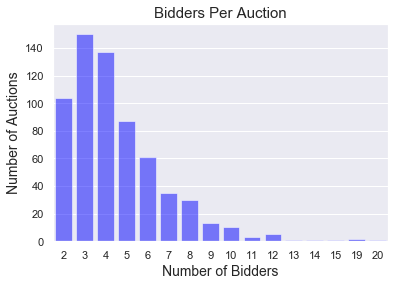

In [77]:
p4 = sns.barplot(x=win_gb['Bidder Count'],y=win_gb['Count'], saturation=1, color='Blue',alpha=0.5)
plt.title('Bidders Per Auction', fontsize=15)
plt.xlabel('Number of Bidders', fontsize=14)
plt.ylabel('Number of Auctions', fontsize=14)
#p4.figure.savefig('boxplot2.jpg', format='jpeg', dpi=1000)

In [36]:
winner['Bid'] = winner['Bid ']
winner['BidderCount'] = winner['Bidder Count']
winner['SmallCount'] = winner['Number of Small Business Bidders']
winner['LargeCount'] = winner['Number of Large Business Bidders']


#add intercept 
model = smf.ols(formula = 'Bid~SmallCount+LargeCount+Estimate',data=winner, missing = 'drop').fit()  # fit the model
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    Bid   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1755.
Date:                Tue, 14 Apr 2020   Prob (F-statistic):          2.08e-307
Time:                        09:42:39   Log-Likelihood:                -8902.0
No. Observations:                 641   AIC:                         1.781e+04
Df Residuals:                     637   BIC:                         1.783e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.003e+05   2.44e+04      8.204      0.0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [37]:
#How many?
print(len(pd.Series(data['Project ID']).unique()))
print(len(pd.Series(data['Company ID']).unique()))
print(len(pd.Series(small['Company ID']).unique()))
np.mean(winner['Small Business Preference']) * 100

641
501
243


40.24960998439938

In [38]:
print(np.mean(data['Log Bid']))
print(np.mean(big['Log Bid']))
print(np.mean(small['Log Bid']))

5.684058832117042
5.732359204838652
5.607422240732097


In [39]:
#data.to_csv('data.csv')

In [40]:
math.log(10)

2.302585092994046